<a href="https://colab.research.google.com/github/FlyingTurkeySandwitch/Comp389Proj1/blob/main/PA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




MZ's note: The original tutorial is [here](https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh). Edits were made due to updates in recent versions of `transformers` and data inaccessibility. Additional comments were added.


============The intro section of the original tutorial starts below===========

This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch.
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Setup

In [ ]:
# transformers have likely been installed in your colab session
# !pip install transformers

In [33]:
import os
import time
import datetime
from google.colab import drive


import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup
import torch.optim as optim

import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


TypeError: 'NoneType' object is not subscriptable

**Make sure you are connected to a GPU**

In [ ]:
!nvidia-smi

Sun Nov  9 23:17:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Create Training Set

The data used to finetune the language model is a dataset of tiny stories was downloaded from [here](https://huggingface.co/datasets/roneneldan/TinyStories). Only the first 1,000 stories were stored in the dataset below.  


In [ ]:
# load into a data frame
filename = 'pa3_data.csv'
df = pd.read_csv(filename)
print(df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'lyrics.csv'

In [ ]:

all_lyrics = df




We need to get an idea of how long our training documents are.

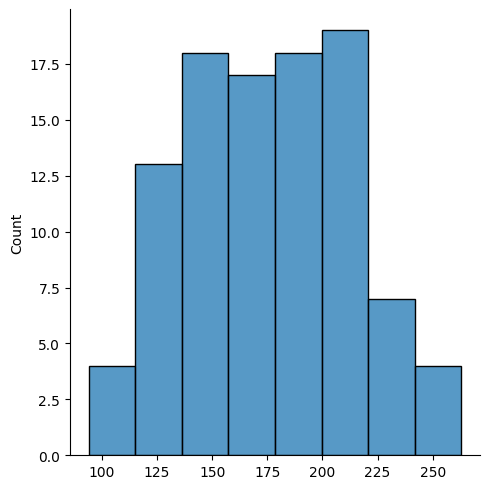

In [ ]:
doc_lengths = []

for story in stories:

    # get rough token count distribution
    tokens = nltk.word_tokenize(story)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths)

In [ ]:
# average document (a single sequence) length
np.average(doc_lengths)

np.float64(175.36)

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>', padding_side='left')
# padding from the left because it's a decoder-only architecture

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

[MZ's note: if you have colab PRO through your educational account, you could use a larger batch size without running into memory problems]

In [ ]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each sentence in the bos (begin of sentence) and eos (end of sentence) tokens.

Every tensor passed to the model should be the same length.

If the text sequence is shorter than `max_length` tokens, it will be padded to a length of `max_length` using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the text sequence is longer than `max_length` tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(stories, tokenizer, max_length=200)
# using max_len=200 due to the average length of our tiny stories.

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   90 training samples
   10 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every N steps, increase N if you don't wish to over-crowd your printouts during training
sample_every = 20

In [ ]:
optimizer = optim.AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

# Push model to device (cuda)
model = model.to(device)

# The PyTorch training loop is similar to what you did in Assignment 2.
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # b_input_ids and b_labels are both set to the input sequences of the batch
        # when we pass them to the model, the model will predict one token at a time
        # till the end of the sequence
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,          # batch input token IDs
                          labels=b_labels,      # batch input token IDs
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample (for human evaluation) every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    b_input_ids,    # Use a batch of input IDs for generation
                                    attention_mask=b_masks, # Pass the attention mask
                                    pad_token_id=tokenizer.pad_token_id, # Set the padding token ID as its ID in our tokenizer, otherwise there will be a warning
                                    do_sample=True,
                                    top_k=50,
                                    max_new_tokens = 100,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        # Update learning rate based on completed optimizer steps
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# The purpose of printing out samples during training: does the generated content get better as your epochs increase?


======== Epoch 1 / 5 ========
Training...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


  Batch    20  of     45. Loss: 2.797633171081543.   Elapsed: 0:00:04.
0: One day, Mary was sitting on the grass in the park, eating a sandwich. She chewed it slowly, looking around. Suddenly, something sparkly caught her eye - it was a silver necklace glistening in the sun. Mary noticed it was near a bush, so she crawled over to take a closer look. 

When she got close, Mary could see that the necklace was suspended from a thin branch. She reached out to take it in her tiny hand and felt it's cool metal. 

Just then, a voice called out from behind her. It was an old woman. 
 
"Do you like it?" she said.

Mary was a bit anxious but nodded and smiled.

"It's yours," the woman said warmly. "I saw you admiring it and thought you might like to have it."

Mary thanked the woman politely, before heading home with the new silver necklace in her pocket. From that day forward, she kept going to the store. They used to make new jewelry for people to wear around their heads. It was more expensive

Let's view the summary of the training process.

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,4.252974,3.055903,0:00:14,0:00:00
2,2.086391,2.098173,0:00:14,0:00:00
3,1.488632,2.213247,0:00:10,0:00:00
4,1.018611,2.249990,0:00:10,0:00:00
5,0.629209,2.516290,0:00:10,0:00:00


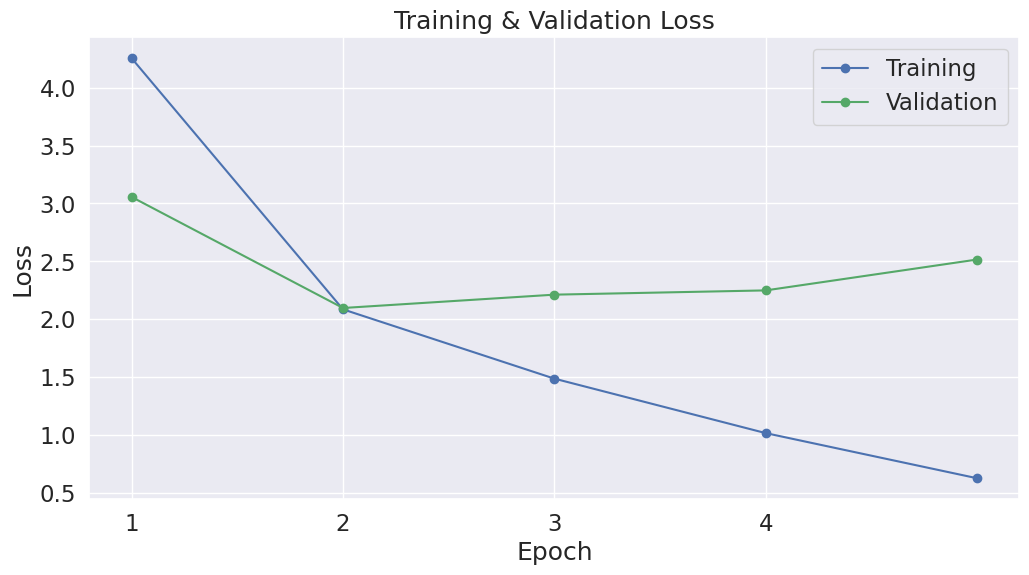

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Hmm, perhaps we don't need five epochs?

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 487564K
-rw-r--r-- 1 root root      1K Nov  9 23:18 added_tokens.json
-rw-r--r-- 1 root root      1K Nov  9 23:18 config.json
-rw-r--r-- 1 root root      1K Nov  9 23:18 generation_config.json
-rw-r--r-- 1 root root    446K Nov  9 23:18 merges.txt
-rw-r--r-- 1 root root 486114K Nov  9 23:18 model.safetensors
-rw-r--r-- 1 root root      1K Nov  9 23:18 special_tokens_map.json
-rw-r--r-- 1 root root      1K Nov  9 23:18 tokenizer_config.json
-rw-r--r-- 1 root root    976K Nov  9 23:18 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/model.safetensors

-rw-r--r-- 1 root root 475M Nov  9 23:18 ./model_save/model.safetensors


In [ ]:
# # Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

# a lot of parameters to tinker with for different generation strategies
sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                max_length = 200,
                                top_k=50,   # sample from the top-k most probable tokens
                                temperature=1.2,  # a parameter to control randomness on the final softmax function!
                                top_p=0.95, # nucleus sampling, sample from the subset of most probable tokens with a cumulative probability of p
                                num_return_sequences=5,
                                pad_token_id=tokenizer.pad_token_id # pass the padding token ID explicitly, otherwise you'd get a warning.
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

0: Once there was a girl named Lily. She had a very special toy, a small spring that she called her toy the LilyPuffy. She loved exploring in the garden. One day, she saw a big pumpkin. She looked at the pumpkin and thought "Why are you here with me?"

Lily looked closer and recognized the pumpkin. She smiled and said "I'm curious. Why are you here exploring?"

The pumpkin smiled again and said "I don't know, I think you should explore more!"

Suddenly, the pumpkin felt a tickle in its branches. It looked down and said, "I am sorry, I think you're not allowed to explore this place."

So Lily said to the pumpkin, "I can't believe I said this! I am sorry, I think you're not allowed to explore here!"

The pumpkin smiled and said, "No, I don't know how to get there. Please, just come with


1: Once upon a time, there was a little girl named Annie. She loved bright things. She would go to the supermarket and get them all, knowing that they would be very, very sun. 

One day, Annie saw a big

Cute stories! Awwww